In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn import linear_model
%matplotlib inline

In [4]:
data = pd.read_csv("diabetes.csv")

In [5]:
data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
data.loc[data["Glucose"]== 0.0, "Glucose"] = np.NAN
data.loc[data["BloodPressure"]== 0.0, "BloodPressure"] = np.NAN
data.loc[data["SkinThickness"]== 0.0, "SkinThickness"] = np.NAN
data.loc[data["Insulin"] == 0.0, "Insulin"] = np.NAN
data.loc[data["BMI"] == 0.0, "BMI"] = np.NAN

data.isnull().sum()[1:6]

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

<Axes: >

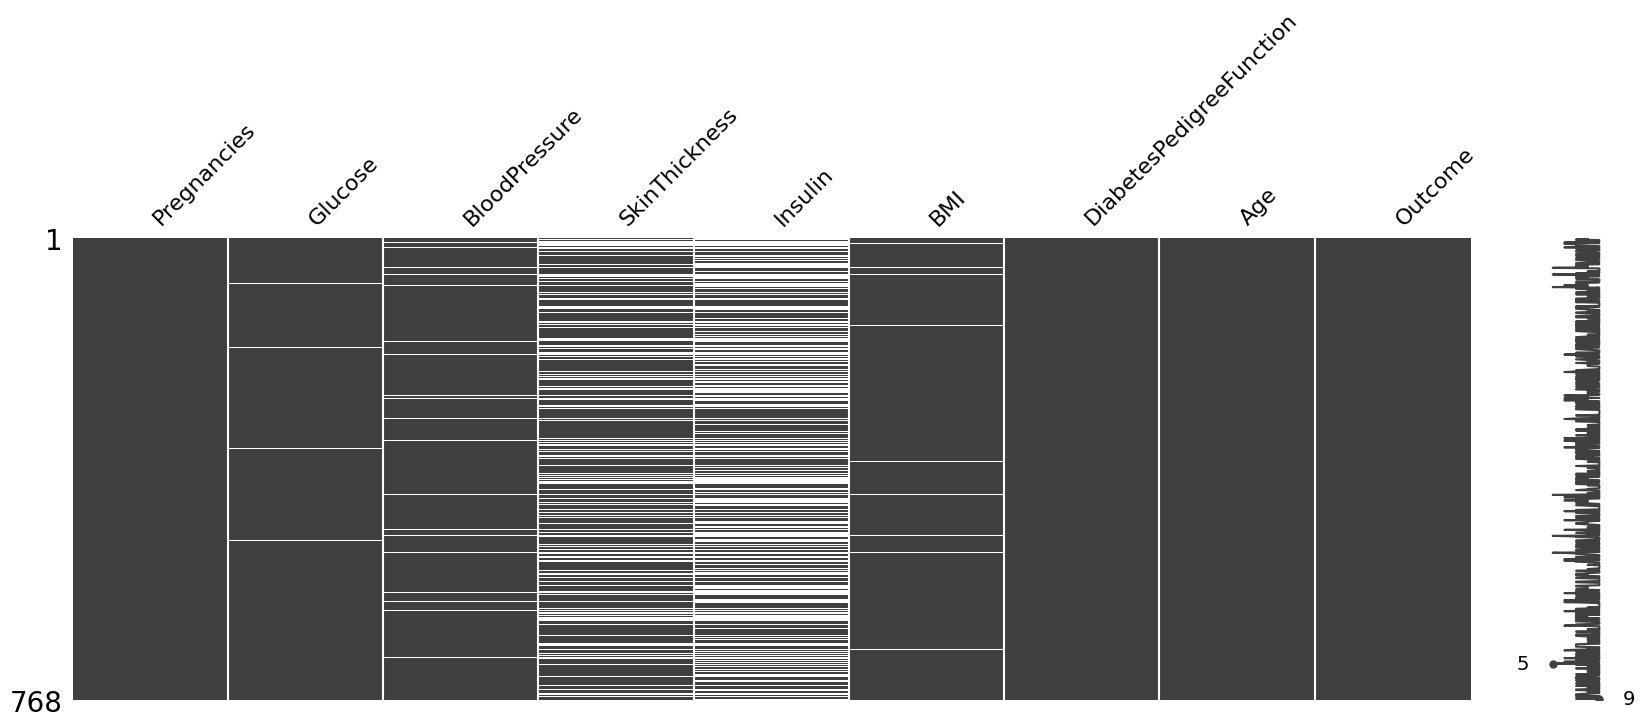

In [9]:
mno.matrix(data, figsize=(20,6))

In [10]:
missing_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

In [11]:
def random_imputation(data, feature):
  number_missing = data[feature].isnull().sum()
  observed_values = data.loc[data[feature].notnull(), feature]
  data.loc[data[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)

  return data

<Axes: >

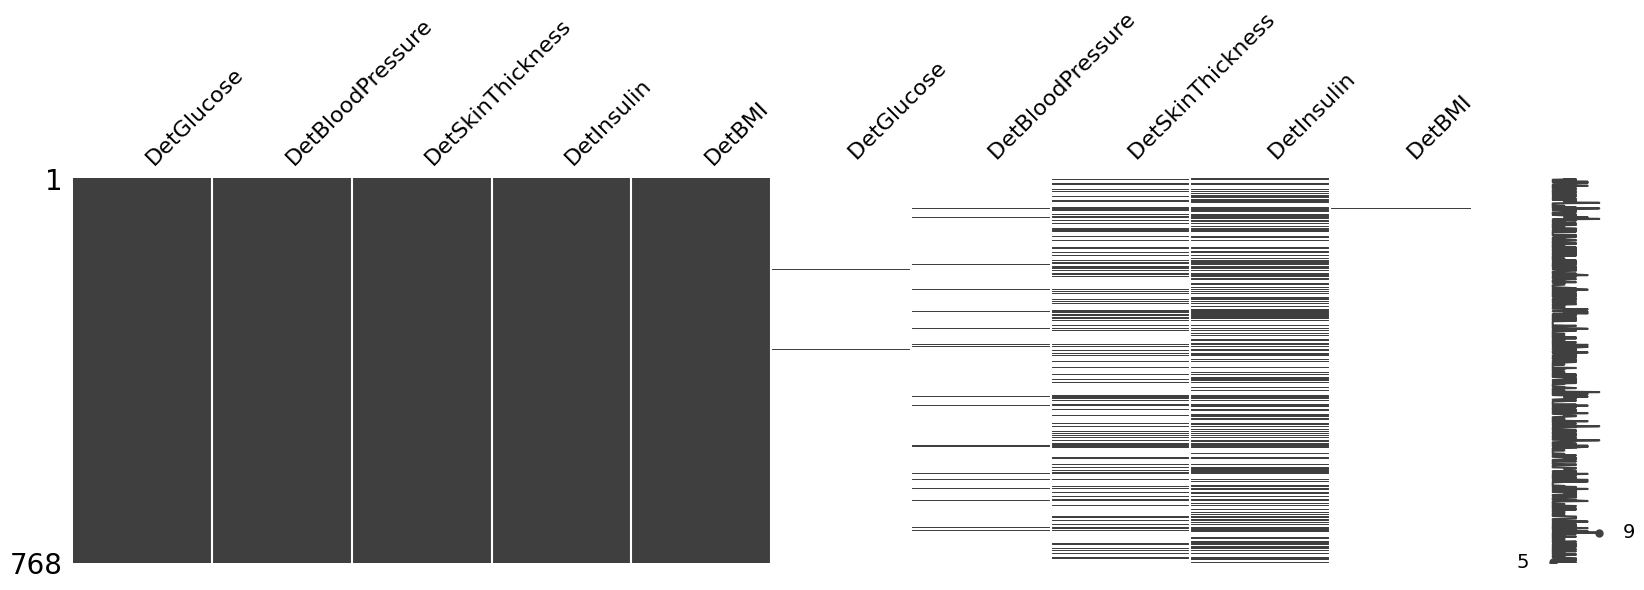

In [12]:
##deterministik
for feature in missing_columns:
  data[feature + '_imp'] = data[feature]
  data = random_imputation(data,feature)
  deter_data = pd.DataFrame(columns = ["Det"+ name for name in missing_columns])

for feature in missing_columns:
  deter_data["Det" + feature] = data[feature + '_imp']
  parameters = list(set(data.columns) - set(missing_columns) - {feature + '_imps'})
  model = linear_model.LinearRegression()
  model.fit(X = data[parameters], y = data[feature + '_imp'])
  deter_data.loc[data[feature].isnull(), " Det" + feature] = model.predict(data[parameters])[data[feature].isnull()]

mno.matrix(deter_data, figsize = (20,5))

In [25]:
##stokastik
for feature in missing_columns:
  data[feature + '_imp'] = data[feature]
  data = random_imputation(data,feature)
  random_data = pd.DataFrame(columns = ["Ran" + name for name in missing_columns])

for feature in missing_columns:
  deter_data["Ran" + feature] = data[feature + '_imp']
  parameters = list(set(data.columns) - set(missing_columns) - {feature + '_imps'})
  model = linear_model.LinearRegression()
  model.fit(X = data[parameters], y = data[feature + '_imp'])

predict = model.predict(data[parameters])
std_error = (predict[data[feature].notnull()] - data.loc[data[feature].notnull(),feature + '_imp']).std()

random_predict = np.random.normal(size = data[feature].shape[0], loc = predict, scale = std_error)
#random_data.loc[(data[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(data[feature].isnull()) & (random_predict > 0)]

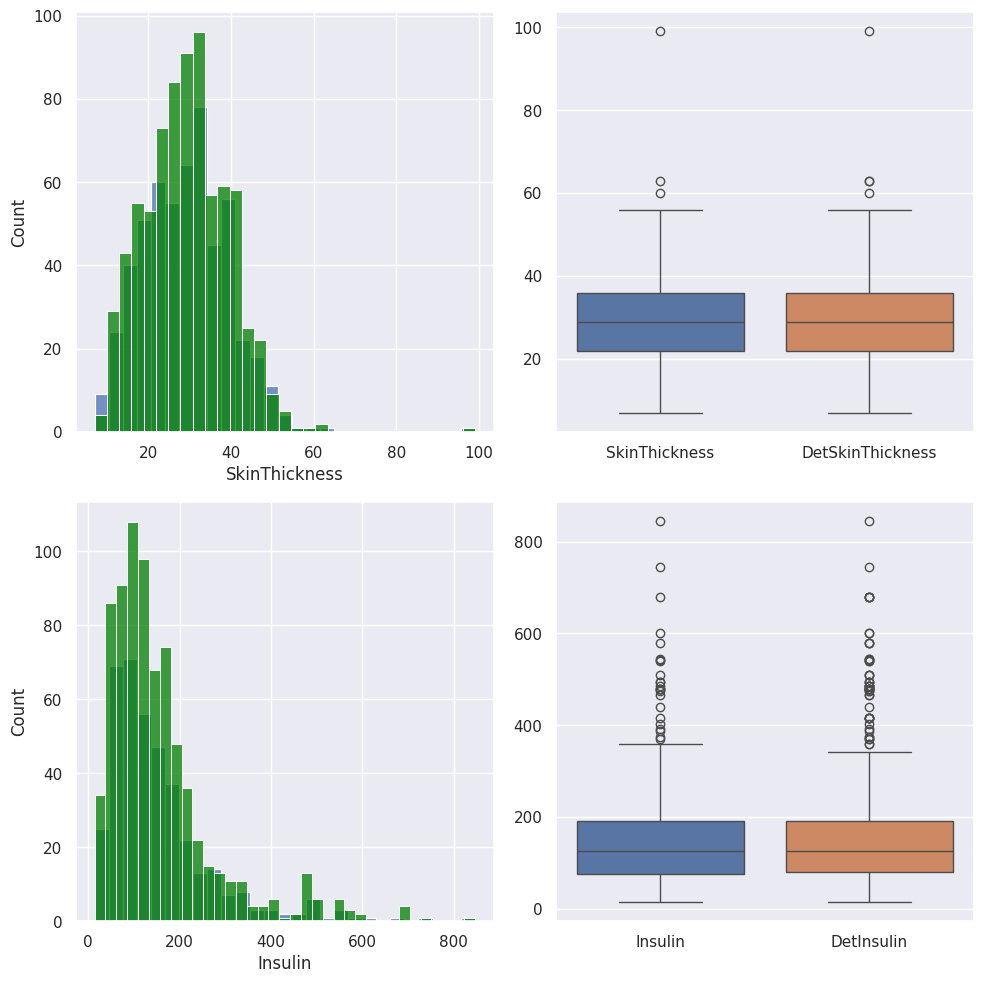

In [19]:
##deterministik
sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(10,10)

for index, variable in enumerate(["SkinThickness", "Insulin"]):
  sns.histplot(data[variable].dropna(), kde = False, ax = axes[index,0])
  sns.histplot(deter_data["Det" + variable], kde = False, ax = axes[index, 0], color = 'green')

  sns.boxplot(data = pd.concat([data[variable], deter_data["Det" + variable]], axis = 1), ax = axes[index,1])

plt.tight_layout()

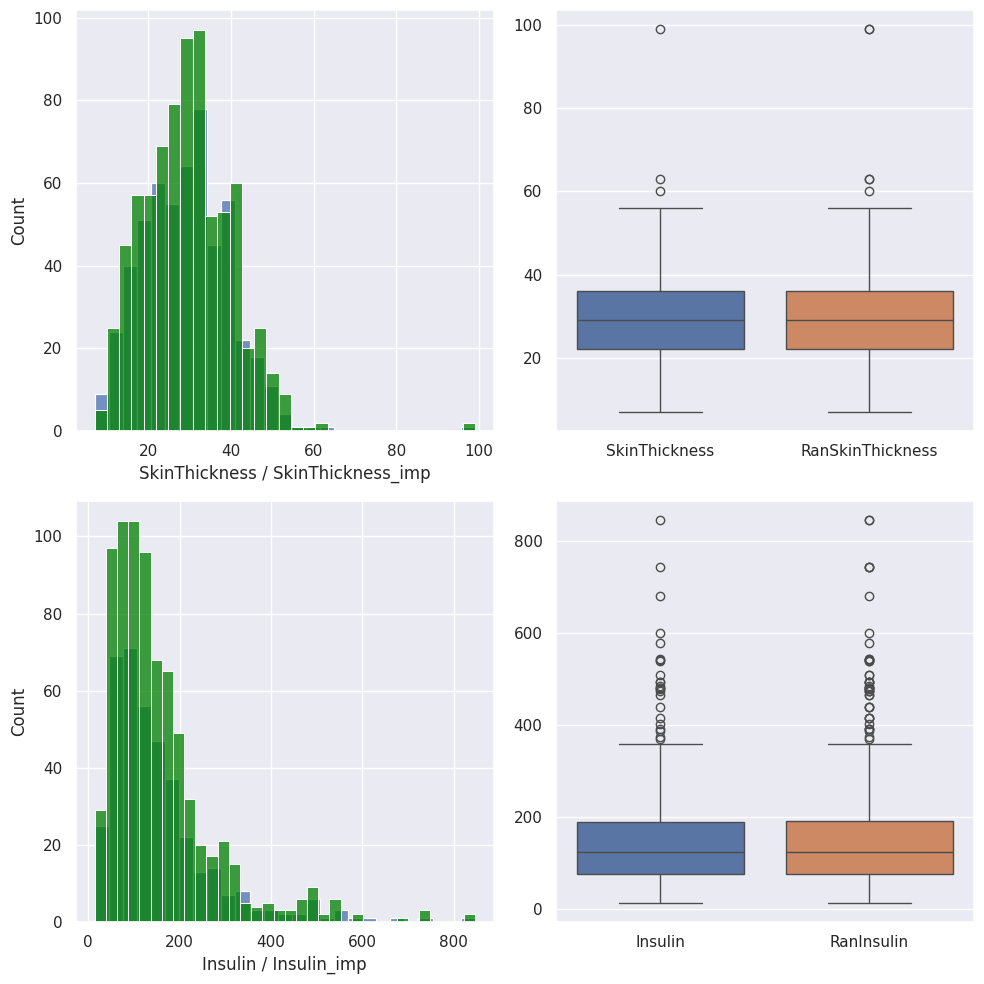

In [29]:
##stokastik
sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(10,10)

for index, variable in enumerate(["SkinThickness", "Insulin"]):
  sns.histplot(data[variable].dropna(), kde = False, ax = axes[index,0])
  sns.histplot(deter_data["Ran" + variable], kde = False, ax = axes[index, 0], color = 'green')
  axes[index, 0].set(xlabel = variable + " / " + variable + '_imp')

  sns.boxplot(data = pd.concat([data[variable], deter_data["Ran" + variable]], axis = 1), ax = axes[index,1])

plt.tight_layout()

In [20]:
##deterministik
pd.concat([data[["Insulin", "SkinThickness"]], deter_data[["DetInsulin", "DetSkinThickness"]]], axis = 1). describe().T

,count,mean,std,min,25%,50%,75%,max
Insulin,394.0,155.548223,118.775855,14.0,76.25,125.0,190.0,846.0
SkinThickness,541.0,29.153420,10.476982,7.0,22.00,29.0,36.0,99.0
DetInsulin,768.0,156.385417,119.231382,14.0,79.00,125.0,190.0,846.0
DetSkinThickness,768.0,29.122396,10.262303,7.0,22.00,29.0,36.0,99.0


In [30]:
##stokastik
pd.concat([data[["Insulin", "SkinThickness"]], deter_data[["RanInsulin", "RanSkinThickness"]]], axis = 1). describe().T

,count,mean,std,min,25%,50%,75%,max
Insulin,394.0,155.548223,118.775855,14.0,76.25,125.0,190.0,846.0
SkinThickness,541.0,29.153420,10.476982,7.0,22.00,29.0,36.0,99.0
RanInsulin,768.0,155.605469,117.538096,14.0,77.00,125.5,192.0,846.0
RanSkinThickness,768.0,29.330729,10.818763,7.0,22.00,29.0,36.0,99.0
